# Evaluation measures for multi-label classification

We first generate multi-labelled random data. These 12x12 images belong to class $i$ iff the $i$-th row contains one and only one pixel. Images can belong to several classes.

In [10]:
%pylab inline
import numpy as np
import h5py
import subprocess
import caffe
from caffe.proto import caffe_pb2
from caffe import layers as L, params as P
from nideep.eval.metrics import example_based_measures, label_based_measures, confusion_matrix_per_class, accuracy_per_class, print_dic
from nideep.eval.metrics import get_inputs_outputs # A SUPPRIMER
from nideep.eval.inference import infer_to_h5_fixed_dims
from learning_curve.mnist_train_test import train_test_net_command

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [29]:
img_size = (12, 12)
lbl_size = (9,)

nb_train_examples = 10000
nb_test_examples = int(1./3 * nb_train_examples)

train_db_path = "db/train2.h5"
test_db_path = "db/test2.h5"

epsilon = 0.1 # coefficient before white noise

def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size
    else:
        x0 = center[0]
        y0 = center[1]
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def generate_data(img_size, lbl_size, nb_examples, generate_labels=True):
    d, l = [], []
    for _ in range(nb_examples):
        data = np.zeros(img_size)
        label = np.zeros(lbl_size)
        nb_blocks = 3 # Number of blocks on a side
        block_size = img_size[0]/nb_blocks
        nb_pixels = np.random.randint(nb_blocks**2)
        while nb_pixels <> 0:
            # choose a block dial
            dial_x = np.random.randint(nb_blocks)
            dial_y = np.random.randint(nb_blocks)
            dial = dial_x + nb_blocks*dial_y
            # write on label
            label[dial] = 1
            center_x = np.random.randint(block_size)
            center_y = np.random.randint(block_size)
            y_beg = block_size*dial_y
            y_end = y_beg + block_size
            x_beg = block_size*dial_x
            x_end = x_beg + block_size
            # write on data
            gaussian = makeGaussian(block_size,fwhm=2,center=(center_x, center_y))
            data[y_beg:y_end, x_beg:x_end] = gaussian
            nb_pixels -= 1
        l.append(label)
        noise = epsilon*np.random.normal(0, 1, img_size)
        d.append([data+noise]) # in brackets [] because one chanel only
    if generate_labels:
        return np.array(d), np.array(l)
    return np.array([d]), None

def save_data(db_path, key_label, key_data, img_size, lbl_size, nb_examples, generate_labels=True):
    d, l = generate_data(img_size, lbl_size, nb_examples, generate_labels)
    with h5py.File(db_path, 'w') as f:
        f.create_dataset(key_data, (nb_examples, 1, img_size[0], img_size[1]), dtype="float32")
        f[key_data][:] = d
        if generate_labels:
            f.create_dataset(key_label, (nb_examples, lbl_size[0]), dtype="float32")
            f[key_label][:] = l
    pass

regenerate_data = True

if regenerate_data:
    save_data(train_db_path, "label", "data", img_size, lbl_size, nb_train_examples)
    save_data(test_db_path, "label", "data", img_size, lbl_size, nb_test_examples)
    print "Data generation: done"

Data generation: done


We define a basic convolutional neural network on the generated data. Ouput loss for backpropagation uses the sigmoid cross-entropy.

In [30]:
def net_(hdf5):
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=100, source=hdf5, ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=2, num_output=50, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu1 = L.ReLU(n.pool1, in_place=True)
    n.conv2 = L.Convolution(n.pool1, kernel_size=1, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    n.fc1 =   L.InnerProduct(n.relu2, num_output=500, weight_filler=dict(type='xavier'))
    n.score =   L.InnerProduct(n.fc1, num_output=lbl_size[0], weight_filler=dict(type='xavier'))
    n.loss =  L.SigmoidCrossEntropyLoss(n.score, n.label)
    n.sigmoid = L.Sigmoid(n.score)
    n.silence = L.Silence(n.sigmoid, ntop=0)
    return n.to_proto()

def solver_(s, net_prefix, train_net_path, test_net_path, solver_config_path):
    # Randomization in training
    s.random_seed = 0xCAFFE
    # Locations of the train/test networks
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 1000  # Test after every 'test_interval' training iterations.
    s.test_iter.append(1000) # Test on 'test_iter' batches each time we test.
    s.max_iter = nb_train_examples # Max training iterations
    # Type of solver
    s.type = "Nesterov" # "SGD", "Adam", and "Nesterov"
    # Initial learning rate and momentum
    s.base_lr = 0.01
    s.momentum = 0.9
    s.weight_decay = 5e-4
    # Learning rate changes
    s.lr_policy = 'inv'
    s.gamma = 0.0001
    s.power = 0.75
    # Display current training loss and accuracy every 10 iterations
    s.display = 10
    # Use GPU to train
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    # Snapshots
    s.snapshot_after_train = True
    s.snapshot_prefix = "snaps/" + net_prefix
    return s

We train and solve the given net using caffe.

In [31]:
net_prefix = "net2"
s = caffe_pb2.SolverParameter()

# Make prototxts
train_net_path = "proto/train2.prototxt"
test_net_path = "proto/test2.prototxt"
solver_config_path = "proto/solver2.prototxt"
with open(train_net_path, "w") as f:
    f.write(str(net_("db/train2.txt")))
with open(test_net_path, "w") as f:
    f.write(str(net_("db/test2.txt")))
with open(solver_config_path, "w") as f:
    f.write(str(solver_(s, net_prefix, train_net_path, test_net_path, solver_config_path)))
    
train_net = True

if train_net:
    train_test_net_command(solver_config_path)
    print "Net training: done"

Net training: done


We now make $n$ inferences and store chosen keys in an hdf5 file. We can visualize the data and some useful multi-label evaluation measures are computed and displayed.

In [32]:
# Inference
make_inference = True
fpath_h5 = "inf/db2.h5"
if make_inference:
    caffemodel = "snaps/"+net_prefix+"_iter_"+str(nb_train_examples)+".caffemodel"
    net = caffe.Net(train_net_path, caffemodel, caffe.TRAIN) # caffe.TEST or caffe.TRAIN???
    keys = ["data", "label", "sigmoid", "score"]
    n = 1000
    x = infer_to_h5_fixed_dims(net, keys, n, fpath_h5, preserve_batch=False)
    print "Inference: done"

Inference: done


true labels
[[ 0.  1.  0.  0.  1.  0.  0.  1.  0.]
 [ 1.  0.  1.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  1.  0.  1.  0.  1.  0.]]

score obtained (%)
[[   0.  100.    0.    0.  100.    0.    0.  100.    0.]
 [ 100.    0.  100.    0.  100.  100.  100.  100.  100.]
 [   0.    0.    0.  100.    0.  100.    0.  100.    0.]]

associated predictions
[[ 0.  1.  0.  0.  1.  0.  0.  1.  0.]
 [ 1.  0.  1.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  1.  0.  1.  0.  1.  0.]]

true image 0



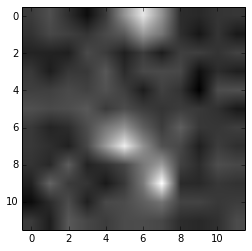

true image 1



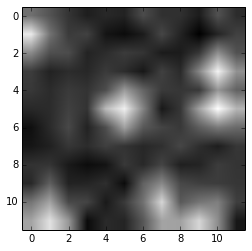

true image 2



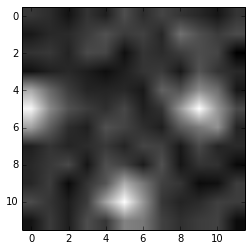

In [33]:
# Visualization of data
nb = 3
key_label = "label"
key_score = "sigmoid"

y_true, y_score, y_pred = get_inputs_outputs(fpath_h5, key_label, key_score, threshold=.5)
with h5py.File(fpath_h5, "r") as f:
    img = f["data"][:]

print "true labels\n", y_true[:nb,:]
print ""
print "score obtained (%)\n", np.rint(100 * y_score[:nb,:])
print ""
print "associated predictions\n", np.rint(y_pred[:nb,:])
print ""
for i in range(nb):
    print "true image {}\n".format(i)
    plt.imshow(np.squeeze(img[i]), cmap='gray')
    plt.show()

Example-based measures
micro_recall
1.0

macro_precision
1.0

macro_recall
1.0

micro_f1
1.0

micro_precision
1.0

macro_f1
1.0

Label-based measures
f1
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]

recall
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]

accuracy_score
1.0

hamming_loss
0.0

precision
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]

Correlation matrices
0
[[65710     0]
 [    0 34290]]

1
[[65560     0]
 [    0 34440]]

2
[[65550     0]
 [    0 34450]]

3
[[65110     0]
 [    0 34890]]

4
[[65860     0]
 [    0 34140]]

5
[[64980     0]
 [    0 35020]]

6
[[65620     0]
 [    0 34380]]

7
[[65250     0]
 [    0 34750]]

8
[[64750     0]
 [    0 35250]]

Accuracies
(0, 1, 2, 3, 4, 5, 6, 7, 8)
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)


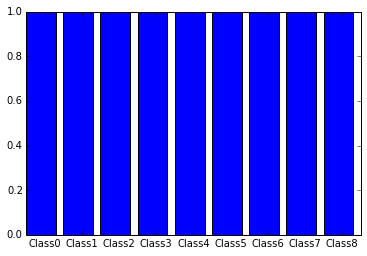

In [34]:
# Compute metrics
key_label, key_score = "label", "sigmoid"

measures1 = example_based_measures(fpath_h5, key_label, key_score, threshold=.5)
measures2 = label_based_measures(fpath_h5, key_label, key_score, threshold=.5)
cm = confusion_matrix_per_class(fpath_h5, key_label, key_score, threshold=.5)
acc = accuracy_per_class(fpath_h5, key_label, key_score, threshold=.5)

# Inline display of measures and confusion matrices for each class
print "====================="
print "Example-based measures"
print "====================="
print_dic(measures1)
print "====================="
print "Label-based measures"
print "====================="
print_dic(measures2)
print "====================="
print "Correlation matrices"
print "====================="
print_dic(cm)

# Histogram of accuracies for each class
print "====================="
print "Accuracies"
print "====================="
fig, ax = plt.subplots()
classes_sorted = range(lbl_size[0])
classes, accuracies = zip(*sorted(acc.items(), key=lambda tup: tup[1]))
print classes
print accuracies
plt.bar(classes_sorted, accuracies)
xTickMarks = ['Class'+str(i) for i in classes]
ax.set_xticks([x+.5 for x in classes_sorted])
xtickNames = ax.set_xticklabels(xTickMarks)
plt.show()